In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [10]:
# Fetch the data from Yahoo finance
ticker = "MSFT"
data = yf.download(ticker, start = "2010-01-01", end = "2024-07-31", interval = "1mo")

[*********************100%***********************]  1 of 1 completed


In [12]:
# Keep only the "Close" column
data = data["Close"]

In [16]:
# Differencing to make the series stationary
data_diff = data.diff().dropna()

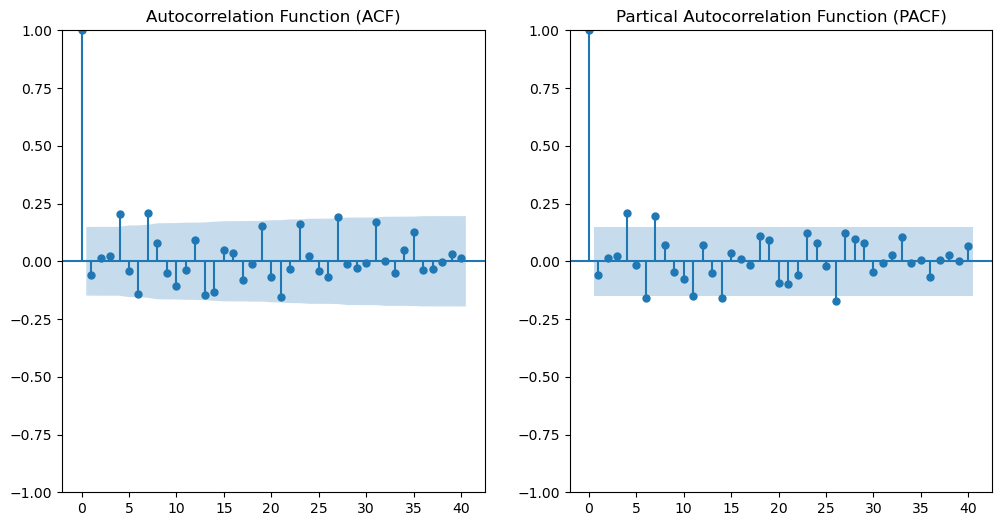

In [18]:
# ACF and PACF plots
plt.figure(figsize = (12,6))
plt.subplot(121)
plot_acf(data_diff, ax = plt.gca(), lags=40)
plt.title("Autocorrelation Function (ACF)")

plt.subplot(122)
plot_pacf(data_diff, ax = plt.gca(), lags=40)
plt.title("Partical Autocorrelation Function (PACF)")

plt.show()

In [20]:
# Model Identification: Using AIC/BIC to select the best ARIMA model
best_aic = np.inf
best_order = None
best_model = None

for p in range(5):
    for d in range(2):
        for q in range(5):
            try:
                model = ARIMA(data, order = (p,d,q)).fit()
                if model.aic <best_aic:
                    best_aic = model.aic
                    best_order = (p,d,q)
                    best_model = model
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed to fit: {e}")
                continue

if best_model is not None:
    print(f"Best ARIMA model: {best_order} with AIC: {best_aic}")
else:
    print("No suitable ARIMA model found")

C:\Users\X_FENG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\X_FENG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\X_FENG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\X_FENG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\X_FENG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No fr

Best ARIMA model: (4, 1, 2) with AIC: 1315.9598944143268


C:\Users\X_FENG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Display statistical results of the best ARIMA model
if best_model is not None:
    print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                  175
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -650.980
Date:                Wed, 20 Nov 2024   AIC                           1315.960
Time:                        11:41:33   BIC                           1338.073
Sample:                    01-01-2010   HQIC                          1324.930
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1316      0.077     -1.716      0.086      -0.282       0.019
ar.L2         -0.6818      0.069     -9.893      0.000      -0.817      -0.547
ar.L3          0.0408      0.072      0.569      0.5

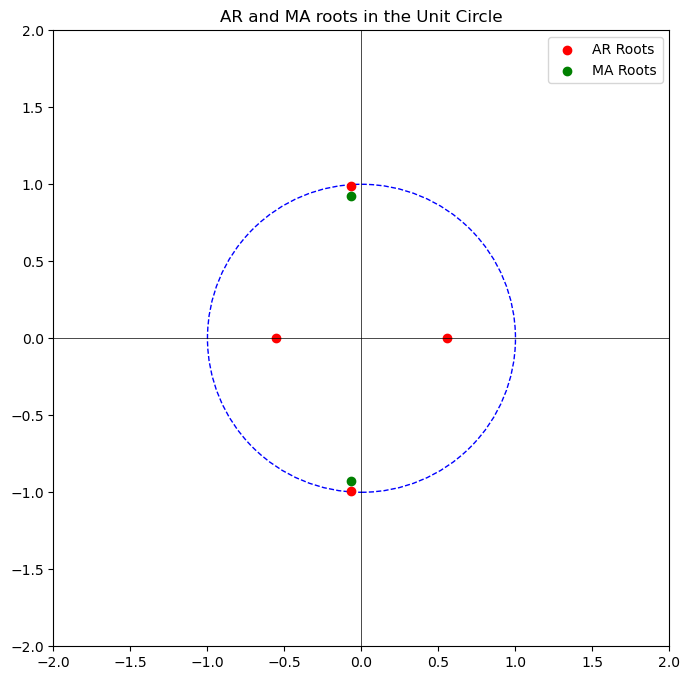

In [40]:
# Plot AR and MA roots in the unit circle
if best_model is not None and best_order[0] >0:
    ar_params = np.r_[1, -best_model.arparams] if best_order[0] >0 else [1]
    ma_params = np.r_[1, best_model.maparams] if best_order[2] >0 else [1]
    
    ar_roots = np.roots(ar_params)
    ma_roots = np.roots(ma_params)

    plt.figure(figsize = (8,8))
    unit_circle = plt.Circle((0,0),1,color = "blue", fill = False, linestyle = "--")
    plt.gca().add_patch(unit_circle)

    plt.scatter(ar_roots.real, ar_roots.imag, color = "red", label = "AR Roots")
    plt.scatter(ma_roots.real, ma_roots.imag, color = "green", label = "MA Roots")

    plt.axhline(0, color = "black", linewidth = 0.5)
    plt.axvline(0, color = "black", linewidth = 0.5)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title("AR and MA roots in the Unit Circle")
    plt.legend()
    plt.show()
    

In [50]:
# Unit Root Graph (ADF Test)
adf_test = sm.tsa.adfuller(data_diff)
print(f"ADF statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF statistic: -3.8685915220032787, p-value: 0.0022785483697087736


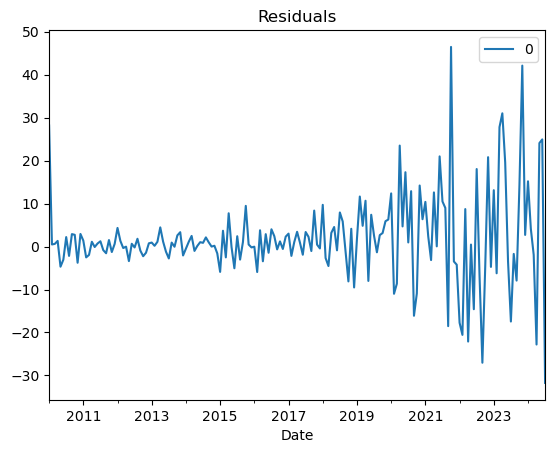

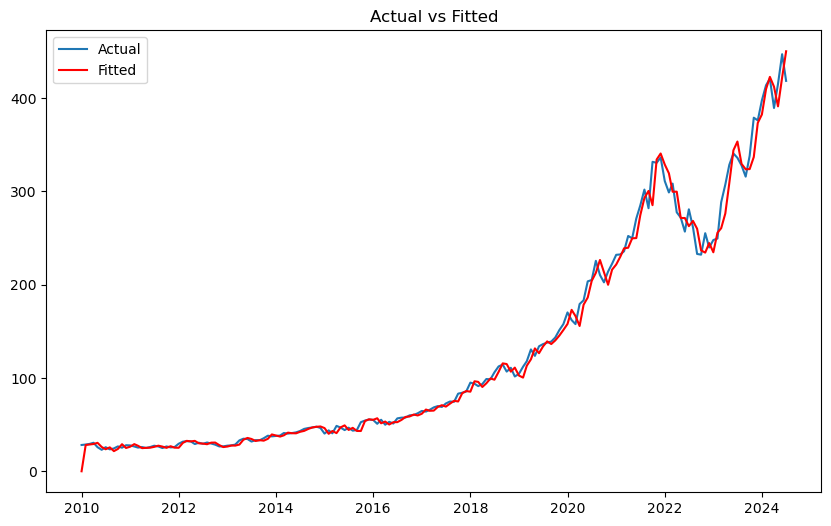

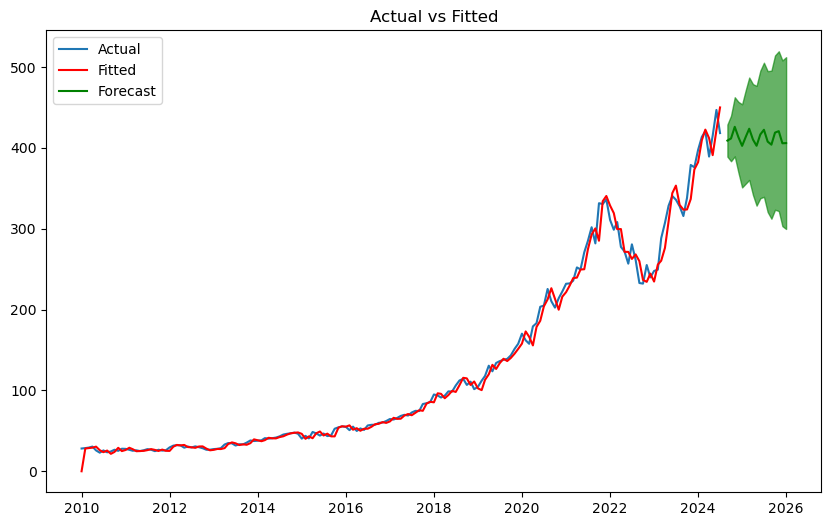

In [66]:
# Residual Plot
if best_model is not None:
    residuals = pd.DataFrame(best_model.resid)
    residuals.plot(title = "Residuals")
    plt.show()

# Actual vs Forecast
    plt.figure(figsize = (10,6))
    plt.plot(data, label="Actual")
    plt.plot(best_model.fittedvalues, color = "red", label ="Fitted")
    plt.legend()
    plt.title("Actual vs Fitted")
    plt.show()

# Forecasting until the end of 2025
    forecast_steps = 17 # Number of months from August 2024 to December 2025
    forecast = best_model.get_forecast(steps = forecast_steps)
    forecast_index = pd.date_range(start = data.index[-1], periods=forecast_steps+1, freq="M")[1:]

# Plot Actual vs Forecast
    plt.figure(figsize = (10,6))
    plt.plot(data, label="Actual")
    plt.plot(best_model.fittedvalues, color = "red", label ="Fitted")
    plt.plot(forecast_index, forecast.predicted_mean, color="green", label="Forecast")
    plt.fill_between(forecast_index, forecast.conf_int().iloc[:,0], forecast.conf_int().iloc[:,1],color = "green", alpha=0.6) # plot confidence interval
    plt.legend()
    plt.title("Actual vs Fitted")
    plt.show()

else: 
    print("Skipping residual and forecase plots since no model was fitted.")

In [64]:
best_model.get_forecast(10).conf_int()


,lower MSFT,upper MSFT
2024-08-01 00:00:00+00:00,389.223228,428.901130
2024-09-01 00:00:00+00:00,383.530785,439.773737
2024-10-01 00:00:00+00:00,389.498469,462.675815
2024-11-01 00:00:00+00:00,369.813928,456.997585
2024-12-01 00:00:00+00:00,351.108253,453.959931
2025-01-01 00:00:00+00:00,355.998584,471.963826
2025-02-01 00:00:00+00:00,360.400533,487.057487
2025-03-01 00:00:00+00:00,341.829683,478.908211
2025-04-01 00:00:00+00:00,328.597972,476.731751
2025-05-01 00:00:00+00:00,337.766776,495.516376
